In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf 
from tensorflow.keras import models, layers 


In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
        '../PotatoDataSet/',
        shuffle=True,
        image_size = (IMAGE_SIZE,IMAGE_SIZE),
        batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


2022-03-15 00:32:44.268976: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
dataset.class_names



['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
class_names = dataset.class_names

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 1 0 0 1 0 0 0 1 0 2 0 1 1 1 0 1 1 1 1 0 0 1 2 0 1 0 0 1 1]


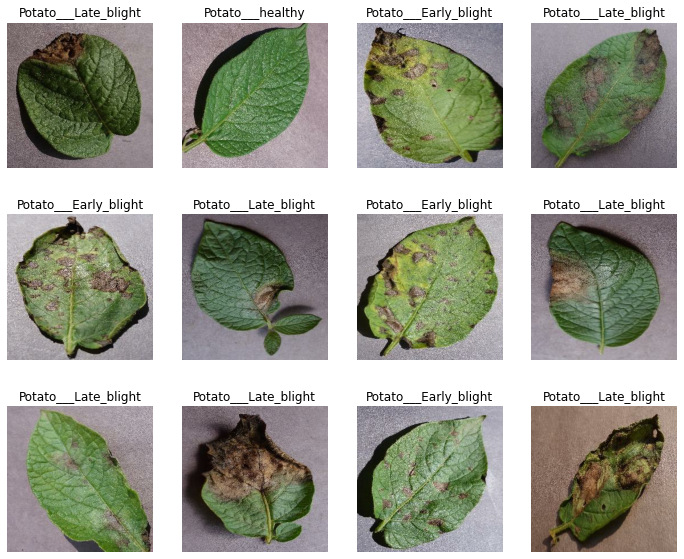

In [8]:

for image_batch, label_batch in dataset.take(1):
    plt.figure(figsize=(12,10))
    for i in range(12):   
         plt.subplot(3,4,i+1)
         plt.imshow(image_batch[i].numpy().astype('uint8'))
         plt.title(class_names[label_batch[i]])
         plt.axis('off')

In [47]:
#80% ==> training 
#20% ==> 10% validation, 10% test

In [9]:
len(dataset)*0.8 

54.400000000000006

In [10]:
train_ds = dataset.take(54)

In [11]:
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)


14

In [13]:
len(dataset)*0.1


6.800000000000001

In [14]:
val_ds = test_ds.take(6) 
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split =0.8, val_split=0.1, test_split=0.1, shuffle=True,
                            shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle: 
        ds = ds.shuffle(shuffle_size, seed =12)
    
    train_size = int(train_split * ds_size)
    val_size = int( val_split * ds_size )
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    
    
    return train_ds,val_ds,test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

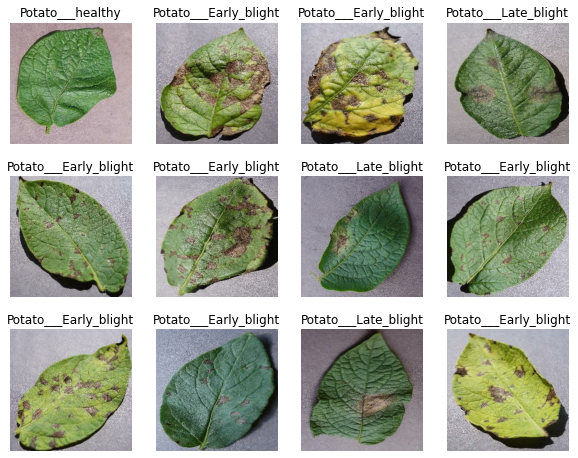

In [20]:
for image_batch, label_batch in val_ds.take(1):
    plt.figure(figsize=(10,8))
    for i in range(12):   
         plt.subplot(3,4,i+1)
         plt.imshow(image_batch[i].numpy().astype('uint8'))
         plt.title(class_names[label_batch[i]])
         plt.axis('off')

In [21]:
len(test_ds)


8

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    
])

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [33]:
image_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

model = Sequential()

model.add(resize_and_rescale)
model.add(data_augmentation)
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, 
                 activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape
                 ,activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape
                 ,activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape
                 ,activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape
                 ,activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape
                 ,activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(64))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its multi-class so we use softmax
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])


In [34]:
model.build(image_shape)

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [36]:
from tensorflow.keras.callbacks import EarlyStopping 

In [37]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [38]:
results = model.fit(train_ds,epochs=20, 
                              validation_data=val_ds,
                              verbose=1
                              )

Epoch 1/20
54/54 [==============================] - 98s 2s/step - loss: 0.9516 - accuracy: 0.4665 - val_loss: 0.8955 - val_accuracy: 0.5018
Epoch 2/20
54/54 [==============================] - 102s 2s/step - loss: 0.8061 - accuracy: 0.5710 - val_loss: 0.6499 - val_accuracy: 0.6960
Epoch 3/20
54/54 [==============================] - 109s 2s/step - loss: 0.6479 - accuracy: 0.7347 - val_loss: 0.5063 - val_accuracy: 0.7864
Epoch 4/20
54/54 [==============================] - 104s 2s/step - loss: 0.4950 - accuracy: 0.8087 - val_loss: 0.4420 - val_accuracy: 0.8034
Epoch 5/20
54/54 [==============================] - 103s 2s/step - loss: 0.4129 - accuracy: 0.8310 - val_loss: 0.3705 - val_accuracy: 0.8286
Epoch 6/20
54/54 [==============================] - 122s 2s/step - loss: 0.4146 - accuracy: 0.8216 - val_loss: 0.3121 - val_accuracy: 0.8944
Epoch 7/20
54/54 [==============================] - 112s 2s/step - loss: 0.3241 - accuracy: 0.8873 - val_loss: 0.4880 - val_accuracy: 0.7805
Epoch 8/20
54/

In [39]:
losses = pd.DataFrame(results.history) 

In [74]:
scores = model.evaluate(test_ds)

54/54 [==============================] - 16s 292ms/step - loss: 0.0871 - accuracy: 0.9701


In [40]:
losses

,loss,accuracy,val_loss,val_accuracy
0,0.951647,0.466549,0.895529,0.501761
1,0.806123,0.571009,0.649899,0.696009
2,0.647916,0.734742,0.506346,0.786385
3,0.495040,0.808685,0.442041,0.803404
4,0.412931,0.830986,0.370490,0.828638
5,0.414573,0.821596,0.312072,0.894366
6,0.324056,0.887324,0.488021,0.780516
7,0.290866,0.900235,0.293836,0.911385
8,0.243485,0.920188,0.383511,0.848005
9,0.227480,0.913146,0.145188,0.942488


<AxesSubplot:>

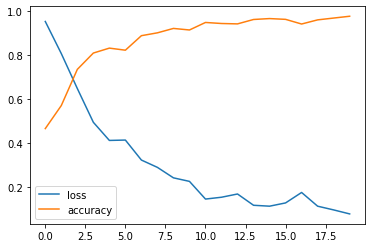

In [41]:
losses[['loss','accuracy']].plot()

Actual : Potato___Early_blight
Predicted Potato___Early_blight


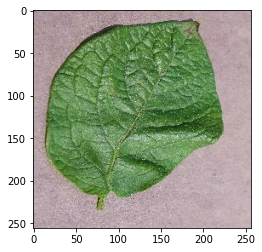

In [42]:
for images_batch, labels_batch in test_ds.take(1):
    for i in range(1):
        first_image = image_batch[i].numpy().astype('uint8')
        first_label = labels_batch[i].numpy()
    
        plt.imshow(first_image)
        print('Actual :',class_names[first_label])

        batch_prediction = model.predict(images_batch)
        print('Predicted',class_names[np.argmax(batch_prediction[0])])

In [43]:
from sklearn.metrics import classification_report,confusion_matrix

In [73]:
pred_probs = model.predict(test_ds)

In [75]:
pred_probs

array([[3.9202808e-07, 4.1788023e-02, 9.5821160e-01],
       [2.0106650e-05, 9.9997985e-01, 4.2604684e-09],
       [2.5886059e-01, 7.4113935e-01, 1.8487381e-08],
       ...,
       [1.6995727e-03, 9.9830014e-01, 3.3576075e-07],
       [6.6695561e-06, 9.9999332e-01, 5.7576919e-08],
       [8.7727989e-05, 9.9986827e-01, 4.3989061e-05]], dtype=float32)

In [49]:
def predict(model, img):
    img_arr = tf.keras.preprocessing.image.img_to_array(img)
    img_arr = tf.expand_dims(img_arr,0)
    
    predictions= model.predict(img_arr)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence 
    
    

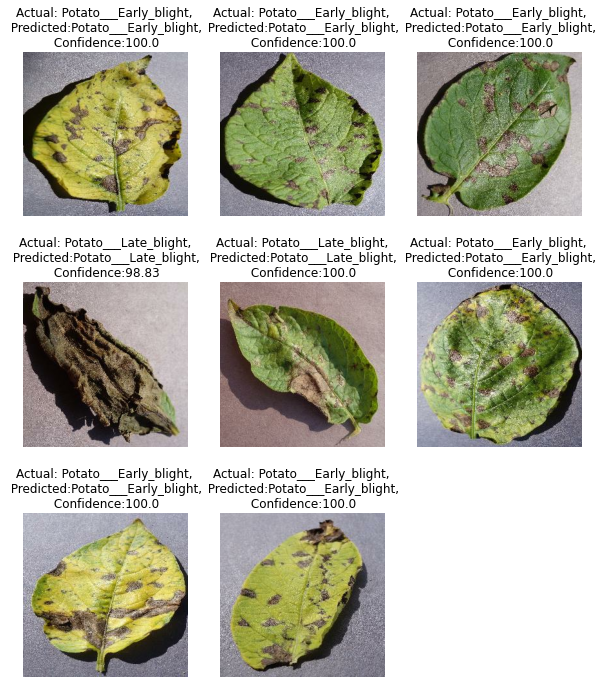

In [72]:
plt.figure(figsize=(10,12))
for images, labels in test_ds:
    
    for i in range(8):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')
        
        predicted_class,confidence = predict(model, images[i].numpy()) 
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted:{predicted_class},\n Confidence:{confidence}")  
        
      


In [421]:
from tensorflow import keras
keras.__version__

'2.8.0'

In [430]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

In [59]:
pd.options.display.max_rows = 4000

In [77]:
model_version = 1
model.save(f"../models/{model_version}")

2022-03-15 01:59:05.923242: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../models/1/assets


In [86]:
import os 
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")

2